In [40]:
from collections import defaultdict
from functools import lru_cache
import sys

class Task:
    """
    Represents a task in the scheduler.

    Attributes
    ----------
    id : int
        Unique identifier for the task.
    description : str
        Short description of the task.
    duration : int
        Task duration in minutes.
    dependencies : list
        List of task IDs that must be completed before this task.
    time_constraint : int or None
        Exact time the task must be started (in minutes), if applicable.
    priority : float or None
        Computed utility value for the task (used for scheduling flexible tasks).
    status : str
        Task status: 'N' (not started), 'C' (completed).
    start_time : int or None
        The time at which this task is scheduled to start.
    """
    def __init__(self, id, description, duration, dependencies, time_constraint=None):
        self.id = id
        self.description = description
        self.duration = duration
        self.dependencies = dependencies
        self.time_constraint = time_constraint
        self.priority = None
        self.status = 'N'
        self.start_time = None


class DPScheduler:
    """
    A globally optimal scheduler that uses dynamic programming across the entire day
    to maximize the total priority score of scheduled tasks.

    Attributes
    ----------
    tasks : list
        List of all Task objects.
    start_time : int
        The start time of the day in minutes.
    end_time : int
        The end time of the day in minutes.
    buffer_time : int
        Buffer time in minutes between tasks.
    schedule : list
        Final list of scheduled (start_time, Task) tuples.
    """
    def __init__(self, tasks, start_time, end_time, buffer_time=5):
        self.tasks = tasks
        self.task_lookup = {task.id: task for task in tasks}
        self.start_time = start_time
        self.end_time = end_time
        self.buffer_time = buffer_time
        self.schedule = []
        self.task_dependencies = defaultdict(list)
        self.priority_cache = {}
        self.fixed_tasks = [t for t in tasks if t.time_constraint is not None]
        self.flexible_tasks = [t for t in tasks if t.time_constraint is None]
        self.populate_dependency_graph()
        self.compute_all_priorities()

    def populate_dependency_graph(self):
        """Constructs a mapping of each task to its dependencies."""
        for task in self.tasks:
            for dep in task.dependencies:
                self.task_dependencies[task.id].append(dep)

    def compute_all_priorities(self):
        """Caches the computed priority for all flexible tasks."""
        for task in self.flexible_tasks:
            task.priority = self.calculate_priority(task)
            self.priority_cache[task.id] = task.priority

    def calculate_priority(self, task):
        """
        Computes the priority value of a flexible task using:
        - Fixed-time dependency boost (P)
        - Dependency chain depth (L)
        - Inverse duration bonus (D)

        Returns
        -------
        float
            Cached or newly computed priority value.
        """
        if task.id in self.priority_cache:
            return self.priority_cache[task.id]

        P_weight, L_weight, D_weight = 100, 10, 1

        def find_earliest_fixed(t):
            times = []
            for dep in self.task_dependencies[t.id]:
                dt = self.task_lookup[dep]
                if dt.time_constraint:
                    times.append(dt.time_constraint)
                else:
                    inner_time = find_earliest_fixed(dt)
                    if inner_time != float("inf"):
                        times.append(inner_time)
            return min(times) if times else float("inf")

        def get_depth(t):
            deps = self.task_dependencies[t.id]
            if not deps:
                return 0
            return 1 + max(get_depth(self.task_lookup[d]) for d in deps)

        earliest_fixed = find_earliest_fixed(task)
        P = 1 / (earliest_fixed + 1) if earliest_fixed != float("inf") else 0
        L = get_depth(task)
        D = 1 / task.duration if task.duration > 0 else 0

        priority = P_weight * P + L_weight * L + D_weight * D
        self.priority_cache[task.id] = priority
        return priority

    def run(self):
        """Runs the DP scheduler to find the optimal schedule."""
        sys.setrecursionlimit(10**6)
        fixed_time_map = {task.time_constraint: task for task in self.fixed_tasks}

        fixed_occupied_minutes = set()
        for task in self.fixed_tasks:
            for minute in range(task.time_constraint, task.time_constraint + task.duration):
                fixed_occupied_minutes.add(minute)

        @lru_cache(maxsize=None)
        def dp(current_time, completed_ids, last_end_time):
            if current_time > self.end_time:
                return 0, []

            completed = set(completed_ids)

            if current_time in fixed_time_map:
                task = fixed_time_map[current_time]
                if all(dep in completed for dep in task.dependencies):
                    next_time = current_time + task.duration + self.buffer_time
                    task.start_time = current_time
                    score, sched = dp(next_time, frozenset(completed | {task.id}), next_time)
                    return score, [(current_time, task)] + sched
                else:
                    return float('-inf'), []

            best_score = float('-inf')
            best_schedule = []

            # flexible task scheduling with fixed-time overlap check
            for task in self.flexible_tasks:
                if task.id in completed or any(dep not in completed for dep in task.dependencies):
                    continue
                start_after = max(current_time, last_end_time + self.buffer_time if last_end_time else current_time)
                end_time = start_after + task.duration

                # skip if overlaps with fixed task window
                if any(minute in fixed_occupied_minutes for minute in range(start_after, end_time)):
                    continue

                if end_time > self.end_time:
                    continue

                score, sched = dp(end_time, frozenset(completed | {task.id}), end_time)
                score += task.priority
                if score > best_score:
                    task.start_time = start_after
                    best_score = score
                    best_schedule = [(start_after, task)] + sched

            # skip time if nothing schedulable now
            if best_score == float('-inf'):
                score, sched = dp(current_time + 1, completed_ids, last_end_time)
                best_score, best_schedule = score, sched

            return best_score, best_schedule

        _, self.schedule = dp(self.start_time, frozenset(), None)
        self.schedule.sort()
        self.print_schedule()



    def print_schedule(self):
        """Displays the final scheduled timeline."""
        print("\nRunning DP Scheduler:\n")
        current_time = self.start_time
        for start, task in self.schedule:
            if current_time < start:
                print(f"⏳ Waiting {start - current_time} minutes until {self.format_time(start)}")
                current_time = start
            print(f"🕰 t={self.format_time(current_time)}")
            print(f"\tStarted '{task.description}' for {task.duration} mins...")
            current_time += task.duration
            print(f"\t✅ t={self.format_time(current_time)}, task completed!")
        print(f"\n🏁 Finished all tasks by {self.format_time(current_time)}!\n")

    def format_time(self, time):
        """Formats time in minutes to HhMM."""
        return f"{time // 60}h{time % 60:02d}"


In [41]:
def test_case1_dp():
    tasks = [
        Task(1, "Wake up", 15, []),
        Task(2, "Morning routine", 20, [1]),
        Task(3, "Breakfast", 30, [2]),
        Task(4, "PCW for class", 90, [3]),
        Task(5, "Class at 11 AM", 90, [4], time_constraint=11 * 60),  # 11:00 AM
        Task(6, "Cooking", 60, []),
        Task(7, "Lunch", 45, [6])
    ]
    scheduler = DPScheduler(tasks, start_time=8 * 60, end_time= 22 * 60, buffer_time=5)
    scheduler.run()

def test_case2_dp():
    tasks = [
        Task(1, "Wake up", 15, []),
        Task(2, "Shower", 20, [1]),
        Task(3, "Breakfast", 30, [2]),
        Task(4, "Morning Class", 90, [], time_constraint=9 * 60),  # 9:00 AM
        Task(5, "PCW Reading for tomorrow", 60, []),
        Task(6, "Group Meeting", 60, [5], time_constraint=13 * 60),  # 1:00 PM
        Task(7, "Exercise", 45, []),
        Task(8, "Apply to Internship", 60, []),
        Task(9, "Call Mom", 20, []),
        Task(10, "Dinner with friends", 90, [], time_constraint=18 * 60),  # 7:00 PM
    ]

    scheduler = DPScheduler(tasks, start_time=7 * 60, end_time=21 * 60)
    scheduler.run()

test_case1_dp()
test_case2_dp()


Running DP Scheduler:

🕰 t=8h00
	Started 'Wake up' for 15 mins...
	✅ t=8h15, task completed!
⏳ Waiting 5 minutes until 8h20
🕰 t=8h20
	Started 'Morning routine' for 20 mins...
	✅ t=8h40, task completed!
⏳ Waiting 5 minutes until 8h45
🕰 t=8h45
	Started 'Breakfast' for 30 mins...
	✅ t=9h15, task completed!
⏳ Waiting 5 minutes until 9h20
🕰 t=9h20
	Started 'PCW for class' for 90 mins...
	✅ t=10h50, task completed!
⏳ Waiting 10 minutes until 11h00
🕰 t=11h00
	Started 'Class at 11 AM' for 90 mins...
	✅ t=12h30, task completed!
⏳ Waiting 10 minutes until 12h40
🕰 t=12h40
	Started 'Cooking' for 60 mins...
	✅ t=13h40, task completed!
⏳ Waiting 5 minutes until 13h45
🕰 t=13h45
	Started 'Lunch' for 45 mins...
	✅ t=14h30, task completed!

🏁 Finished all tasks by 14h30!


Running DP Scheduler:

🕰 t=7h00
	Started 'Wake up' for 15 mins...
	✅ t=7h15, task completed!
⏳ Waiting 5 minutes until 7h20
🕰 t=7h20
	Started 'Shower' for 20 mins...
	✅ t=7h40, task completed!
⏳ Waiting 5 minutes until 7h45
🕰 t=7h45


In [42]:
from collections import defaultdict

class GreedyTaskScheduler:
    """
    A greedy scheduler that selects the next task to schedule based on its priority value,
    assuming no multitasking and treating fixed-time tasks as hard constraints.

    Attributes
    ----------
    tasks : list
        List of Task objects to be scheduled.
    start_time : int
        Starting time of the scheduler in minutes (e.g., 8 AM = 480).
    end_time : int
        Ending time of the scheduler in minutes (e.g., 10 PM = 1320).
    buffer_time : int
        Time (in minutes) inserted between tasks to simulate transitions.
    schedule : list
        Final list of (start_time, Task) tuples representing the schedule.
    task_lookup : dict
        Dictionary mapping task IDs to Task objects.
    fixed_tasks : dict
        Dictionary of fixed-time tasks indexed by their scheduled start time.
    flexible_tasks : list
        List of tasks that can be scheduled flexibly (without fixed time constraints).
    task_dependencies : defaultdict
        Mapping from task ID to a list of IDs it depends on.
    occupied_minutes : set
        Tracks the minutes that are already blocked by scheduled tasks.
    priority_cache : dict
        Stores computed priorities to avoid recomputation.
    """

    def __init__(self, tasks, start_time, end_time, buffer_time=5):
        self.tasks = tasks
        self.start_time = start_time
        self.end_time = end_time
        self.buffer_time = buffer_time
        self.schedule = []
        self.task_lookup = {task.id: task for task in tasks}
        self.fixed_tasks = {t.time_constraint: t for t in tasks if t.time_constraint is not None}
        self.flexible_tasks = [t for t in tasks if t.time_constraint is None]
        self.task_dependencies = defaultdict(list)
        self.occupied_minutes = set()
        self.priority_cache = {}
        self.populate_dependency_graph()
        self.compute_all_priorities()
        self.reserve_fixed_task_windows()

    def populate_dependency_graph(self):
        """
        Constructs the dependency graph for the tasks.
        """
        for task in self.tasks:
            for dep in task.dependencies:
                self.task_dependencies[task.id].append(dep)

    def compute_all_priorities(self):
        """
        Calculates and caches the priority of each flexible task.
        """
        for task in self.flexible_tasks:
            task.priority = self.calculate_priority(task)
            self.priority_cache[task.id] = task.priority

    def calculate_priority(self, task):
        """
        Computes the priority (utility) of a task based on three components:
        - Fixed-time dependency proximity (P)
        - Dependency chain depth (L)
        - Inverse duration bonus (D)

        Returns
        -------
        float
            The total computed priority score of the task.
        """
        if task.id in self.priority_cache:
            return self.priority_cache[task.id]

        P_weight, L_weight, D_weight = 100, 10, 1

        def find_earliest_fixed(t):
            times = []
            for dep in self.task_dependencies[t.id]:
                dt = self.task_lookup[dep]
                if dt.time_constraint:
                    times.append(dt.time_constraint)
                else:
                    inner_time = find_earliest_fixed(dt)
                    if inner_time != float("inf"):
                        times.append(inner_time)
            return min(times) if times else float("inf")

        def get_depth(t):
            deps = self.task_dependencies[t.id]
            if not deps:
                return 0
            return 1 + max(get_depth(self.task_lookup[d]) for d in deps)

        earliest_fixed = find_earliest_fixed(task)
        P = 1 / (earliest_fixed + 1) if earliest_fixed != float("inf") else 0
        L = get_depth(task)
        D = 1 / task.duration if task.duration > 0 else 0

        priority = P_weight * P + L_weight * L + D_weight * D
        self.priority_cache[task.id] = priority
        return priority

    def reserve_fixed_task_windows(self):
        """
        Reserves the time blocks occupied by fixed-time tasks to prevent conflicts.
        """
        for start_time, task in self.fixed_tasks.items():
            for minute in range(start_time, start_time + task.duration):
                self.occupied_minutes.add(minute)
            self.schedule.append((start_time, task))

    def run(self):
        """
        Runs the greedy scheduling algorithm:
        - Prioritizes fixed-time tasks at their scheduled times.
        - Selects the highest-priority valid flexible task for all remaining time.
        - Advances time step by step until the schedule ends.
        """
        current_time = self.start_time
        completed = set()

        print("\nRunning Greedy Scheduler:\n")

        while current_time < self.end_time:
            # execute fixed-time task if scheduled and dependencies are met
            if current_time in self.fixed_tasks:
                task = self.fixed_tasks[current_time]
                if all(dep in completed for dep in task.dependencies):
                    print(f"🕰 t={self.format_time(current_time)}")
                    print(f"\tStarted '{task.description}' for {task.duration} mins...")
                    current_time += task.duration
                    print(f"\t✅ t={self.format_time(current_time)}, task completed!")
                    completed.add(task.id)
                    current_time += self.buffer_time
                    continue

            # try to schedule the best flexible task available
            valid_tasks = [
                task for task in self.flexible_tasks
                if task.id not in completed
                and all(dep in completed for dep in task.dependencies)
                and self.can_schedule(current_time, task.duration)
            ]
            if valid_tasks:
                task = max(valid_tasks, key=lambda t: t.priority)
                self.schedule.append((current_time, task))
                self.mark_time_as_occupied(current_time, task.duration)
                print(f"🕰 t={self.format_time(current_time)}")
                print(f"\tStarted '{task.description}' for {task.duration} mins...")
                current_time += task.duration
                print(f"\t✅ t={self.format_time(current_time)}, task completed!")
                completed.add(task.id)
                current_time += self.buffer_time
            else:
                current_time += 1

        print(f"\n🏁 Finished greedy scheduling by {self.format_time(current_time)}\n")

    def can_schedule(self, start_time, duration):
        """
        Checks whether the given task can be scheduled without overlapping
        previously occupied time slots.

        Parameters
        ----------
        start_time : int
            Proposed start time of the task.
        duration : int
            Duration of the task.

        Returns
        -------
        bool
            True if the task fits in the schedule, False otherwise.
        """
        return all(
            (start_time + offset) not in self.occupied_minutes
            for offset in range(duration)
        )

    def mark_time_as_occupied(self, start_time, duration):
        """
        Marks the minutes occupied by a task (including buffer) as used.

        Parameters
        ----------
        start_time : int
            Start time of the task.
        duration : int
            Task duration.
        """
        for minute in range(start_time, start_time + duration + self.buffer_time):
            self.occupied_minutes.add(minute)

    def format_time(self, time):
        """
        Formats a time in minutes into 'HhMM' format.

        Parameters
        ----------
        time : int
            Time in minutes from midnight.

        Returns
        -------
        str
            Time formatted as hours and minutes.
        """
        return f"{time // 60}h{time % 60:02d}"


In [43]:
def test_case1_greedy():
    tasks = [
        Task(1, "Wake up", 15, []),
        Task(2, "Morning routine", 20, [1]),
        Task(3, "Breakfast", 30, [2]),
        Task(4, "PCW for class", 90, [3]),
        Task(5, "Class at 11 AM", 90, [4], time_constraint=11 * 60),
        Task(6, "Cooking", 60, []),
        Task(7, "Lunch", 45, [6])
    ]
    scheduler = GreedyTaskScheduler(tasks, start_time=8 * 60, end_time=22 * 60, buffer_time=5)
    scheduler.run()

def test_case2_greedy():
    tasks = [
        Task(1, "Wake up", 15, []),
        Task(2, "Shower", 20, [1]),
        Task(3, "Breakfast", 30, [2]),
        Task(4, "Morning Class", 90, [], time_constraint=9 * 60),  # 9:00 AM
        Task(5, "PCW Reading for tomorrow", 60, []),
        Task(6, "Group Meeting", 60, [5], time_constraint=13 * 60),  # 1:00 PM
        Task(7, "Exercise", 45, []),
        Task(8, "Apply to Internship", 60, []),
        Task(9, "Call Mom", 20, []),
        Task(10, "Dinner with friends", 90, [], time_constraint=18 * 60),  # 7:00 PM
    ]

    scheduler = GreedyTaskScheduler(tasks, start_time=7 * 60, end_time=21 * 60)
    scheduler.run()

test_case1_greedy()
test_case2_greedy()


Running Greedy Scheduler:

🕰 t=8h00
	Started 'Wake up' for 15 mins...
	✅ t=8h15, task completed!
🕰 t=8h20
	Started 'Morning routine' for 20 mins...
	✅ t=8h40, task completed!
🕰 t=8h45
	Started 'Breakfast' for 30 mins...
	✅ t=9h15, task completed!
🕰 t=9h20
	Started 'PCW for class' for 90 mins...
	✅ t=10h50, task completed!
🕰 t=11h00
	Started 'Class at 11 AM' for 90 mins...
	✅ t=12h30, task completed!
🕰 t=12h35
	Started 'Cooking' for 60 mins...
	✅ t=13h35, task completed!
🕰 t=13h40
	Started 'Lunch' for 45 mins...
	✅ t=14h25, task completed!

🏁 Finished greedy scheduling by 22h00


Running Greedy Scheduler:

🕰 t=7h00
	Started 'Wake up' for 15 mins...
	✅ t=7h15, task completed!
🕰 t=7h20
	Started 'Shower' for 20 mins...
	✅ t=7h40, task completed!
🕰 t=7h45
	Started 'Breakfast' for 30 mins...
	✅ t=8h15, task completed!
🕰 t=8h20
	Started 'Call Mom' for 20 mins...
	✅ t=8h40, task completed!
🕰 t=9h00
	Started 'Morning Class' for 90 mins...
	✅ t=10h30, task completed!
🕰 t=10h35
	Started 'Exercis

Running experiments for n=5... 
Running DP Scheduler:

🕰 t=8h00
	Started 'Task 0' for 5 mins...
	✅ t=8h05, task completed!
⏳ Waiting 5 minutes until 8h10
🕰 t=8h10
	Started 'Task 1' for 18 mins...
	✅ t=8h28, task completed!
⏳ Waiting 5 minutes until 8h33
🕰 t=8h33
	Started 'Task 2' for 29 mins...
	✅ t=9h02, task completed!
⏳ Waiting 5 minutes until 9h07
🕰 t=9h07
	Started 'Task 3' for 184 mins...
	✅ t=12h11, task completed!
⏳ Waiting 5 minutes until 12h16
🕰 t=12h16
	Started 'Task 4' for 193 mins...
	✅ t=15h29, task completed!

🏁 Finished all tasks by 15h29!


Running DP Scheduler:

🕰 t=8h00
	Started 'Task 1' for 102 mins...
	✅ t=9h42, task completed!
⏳ Waiting 5 minutes until 9h47
🕰 t=9h47
	Started 'Task 3' for 196 mins...
	✅ t=13h03, task completed!
⏳ Waiting 5 minutes until 13h08
🕰 t=13h08
	Started 'Task 4' for 77 mins...
	✅ t=14h25, task completed!
⏳ Waiting 93 minutes until 15h58
🕰 t=15h58
	Started 'Task 0' for 30 mins...
	✅ t=16h28, task completed!

🏁 Finished all tasks by 16h28!


R

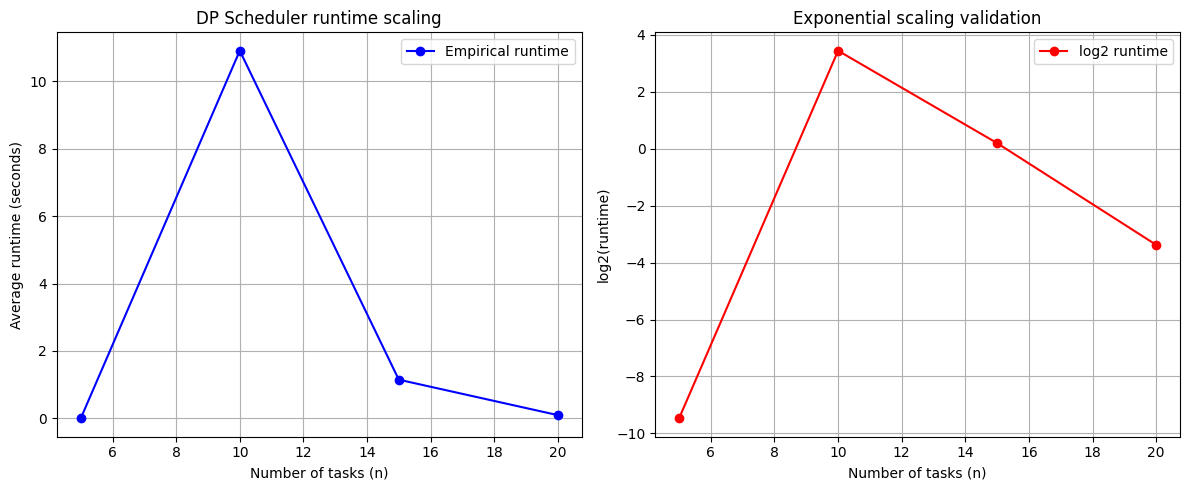


Final results:
N	Avg runtime(s)	Scaling factor
----------------------------------------
5	0.0014	-
10	10.9092	5.99
15	1.1486	0.64
20	0.0964	0.61

Empirical time complexity: O(1.23^n)
Note: Scaling factor shows the average runtime multiplier per additional task


In [44]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.stats import linregress

def generate_random_tasks(num_tasks, max_duration=240, dependency_prob=0.3, fixed_prob=0.2):
    tasks = []
    for i in range(num_tasks):
        duration = random.randint(1, max_duration)
        dependencies = [j for j in range(i) if random.random() < dependency_prob]
        time_constraint = random.randint(0, 1440) if random.random() < fixed_prob else None
        tasks.append(Task(
            id=i,
            description=f"Task {i}",
            duration=duration,
            dependencies=dependencies,
            time_constraint=time_constraint
        ))
    return tasks

def run_experiment(max_tasks, trials):
    input_sizes = list(range(5, max_tasks+1, 5))
    runtimes = []

    for size in input_sizes:
        print(f"Running experiments for n={size}...", end=' ', flush=True)
        trial_times = []

        for _ in range(trials):
            tasks = generate_random_tasks(size)
            scheduler = DPScheduler(tasks, start_time=8*60, end_time=22*60)

            start_time = time.time()
            scheduler.run()
            end_time = time.time()

            trial_times.append(end_time - start_time)

        avg_time = sum(trial_times)/trials
        runtimes.append(avg_time)
        print(f"Average runtime: {avg_time:.3f}s")

    scaling_factors = []
    for i in range(1, len(runtimes)):
        factor = runtimes[i] / runtimes[i-1]
        n_increase = input_sizes[i] - input_sizes[i-1]
        scaling_factors.append(factor ** (1/n_increase))  # per-task scaling factor

    # perform linear regression on log-scale data
    slope, intercept, r_value, p_value, std_err = linregress(input_sizes, np.log2(runtimes))
    empirical_complexity = 2**slope

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(input_sizes, runtimes, 'bo-', label='Empirical runtime')
    plt.xlabel('Number of tasks (n)')
    plt.ylabel('Average runtime (seconds)')
    plt.title('DP Scheduler runtime scaling')
    plt.grid(True)
    plt.legend()

    # log scale plot
    plt.subplot(1, 2, 2)
    plt.plot(input_sizes, np.log2(runtimes), 'ro-', label='log2 runtime')
    plt.xlabel('Number of tasks (n)')
    plt.ylabel('log2(runtime)')
    plt.title('Exponential scaling validation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return input_sizes, runtimes, scaling_factors, empirical_complexity

if __name__ == "__main__":

    input_sizes, runtimes, scaling_factors, empirical_complexity = run_experiment(max_tasks=20, trials=5)

    print("\nFinal results:")
    print("N\tAvg runtime(s)\tScaling factor")
    print("-"*40)
    for i, (n, t) in enumerate(zip(input_sizes, runtimes)):
        if i == 0:
            print(f"{n}\t{t:.4f}\t-")
        else:
            print(f"{n}\t{t:.4f}\t{scaling_factors[i-1]:.2f}")

    print(f"\nEmpirical time complexity: O({empirical_complexity:.2f}^n)")
    print("Note: Scaling factor shows the average runtime multiplier per additional task")


Running Greedy Scheduler:

🕰 t=8h00
	Started 'Task 0' for 41 mins...
	✅ t=8h41, task completed!
🕰 t=8h46
	Started 'Task 3' for 54 mins...
	✅ t=9h40, task completed!
🕰 t=9h45
	Started 'Task 1' for 208 mins...
	✅ t=13h13, task completed!
🕰 t=13h18
	Started 'Task 2' for 101 mins...
	✅ t=14h59, task completed!
🕰 t=15h04
	Started 'Task 4' for 124 mins...
	✅ t=17h08, task completed!

🏁 Finished greedy scheduling by 22h00


Running Greedy Scheduler:

🕰 t=8h00
	Started 'Task 3' for 13 mins...
	✅ t=8h13, task completed!
🕰 t=8h18
	Started 'Task 2' for 50 mins...
	✅ t=9h08, task completed!
🕰 t=9h13
	Started 'Task 1' for 194 mins...
	✅ t=12h27, task completed!
🕰 t=12h32
	Started 'Task 0' for 203 mins...
	✅ t=15h55, task completed!
🕰 t=16h00
	Started 'Task 4' for 20 mins...
	✅ t=16h20, task completed!

🏁 Finished greedy scheduling by 22h00


Running Greedy Scheduler:

🕰 t=8h00
	Started 'Task 0' for 62 mins...
	✅ t=9h02, task completed!
🕰 t=9h07
	Started 'Task 1' for 221 mins...
	✅ t=12h48, task co

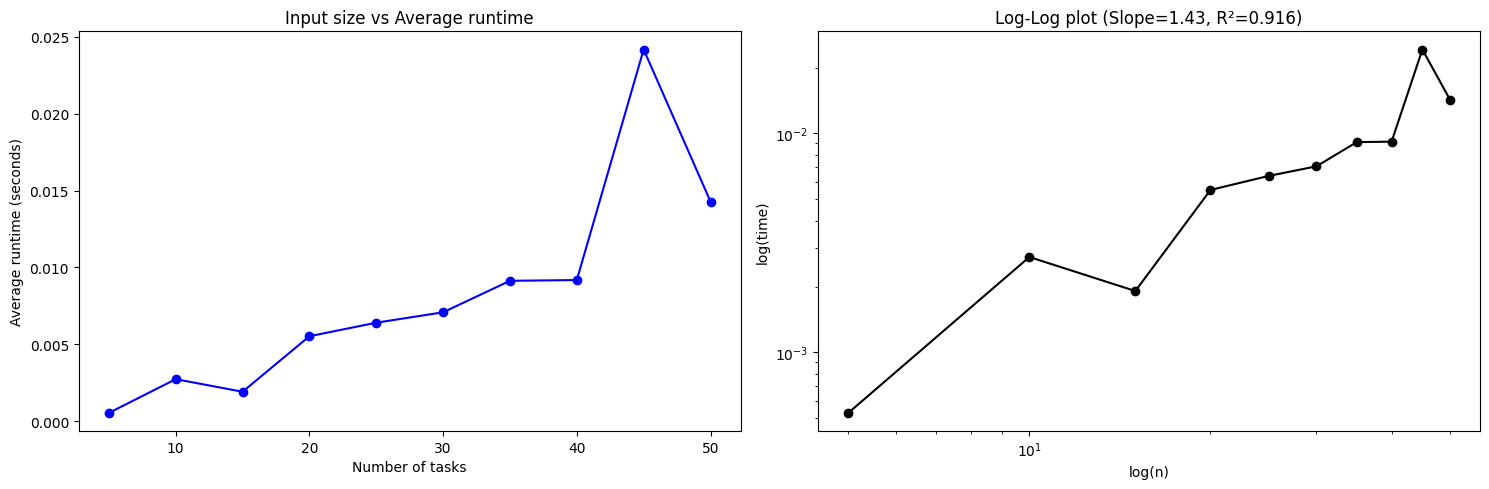


Empirical complexity analysis:
Regression slope: 1.430
R-squared: 0.9160

Scaling factor table:
N	Time(s)	N-ratio	Time-ratio	Scaling
--------------------------------------------------
10	0.0027	2.0	5.15		2.58
15	0.0019	1.5	0.70		0.47
20	0.0055	1.3	2.89		2.17
25	0.0064	1.2	1.16		0.93
30	0.0071	1.2	1.11		0.92
35	0.0091	1.2	1.29		1.11
40	0.0092	1.1	1.01		0.88
45	0.0242	1.1	2.63		2.34
50	0.0143	1.1	0.59		0.53


In [35]:
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def run_experiment(max_tasks=50, trials=5):
    input_sizes = list(range(5, max_tasks+1, 5))
    runtimes = []
    scaling_factors = []

    for size in input_sizes:
        trial_times = []
        for _ in range(trials):
            tasks = generate_random_tasks(size)
            scheduler = GreedyTaskScheduler(tasks, 480, 1320)

            start = time.perf_counter()
            scheduler.run()
            trial_times.append(time.perf_counter() - start)

        avg_time = np.mean(trial_times)
        runtimes.append(avg_time)

        if len(runtimes) > 1:
            prev_size = input_sizes[len(runtimes)-2]
            scaling_factor = (avg_time / runtimes[-2]) / (size / prev_size)
            scaling_factors.append(scaling_factor)

        print(f"N={size:5d} | Time={avg_time:.6f}s | Scaling={scaling_factors[-1]:.2f}" if scaling_factors else "")

    # complexity analysis
    log_sizes = np.log(input_sizes)
    log_times = np.log(runtimes)
    slope, intercept, r_value, _, _ = linregress(log_sizes, log_times)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(input_sizes, runtimes, 'bo-')
    plt.xlabel('Number of tasks')
    plt.ylabel('Average runtime (seconds)')
    plt.title('Input size vs Average runtime')

    # log-log Plot
    plt.subplot(1, 2, 2)
    plt.loglog(input_sizes, runtimes, 'ko-')
    plt.xlabel('log(n)')
    plt.ylabel('log(time)')
    plt.title(f'Log-Log plot (Slope={slope:.2f}, R²={r_value**2:.3f})')
    plt.tight_layout()
    plt.show()

    print("\nEmpirical complexity analysis:")
    print(f"Regression slope: {slope:.3f}")
    print(f"R-squared: {r_value**2:.4f}")
    print("\nScaling factor table:")
    print("N\tTime(s)\tN-ratio\tTime-ratio\tScaling")
    print("-"*50)
    for i in range(1, len(input_sizes)):
        n_ratio = input_sizes[i]/input_sizes[i-1]
        t_ratio = runtimes[i]/runtimes[i-1]
        print(f"{input_sizes[i]}\t{runtimes[i]:.4f}\t{n_ratio:.1f}\t{t_ratio:.2f}\t\t{t_ratio/n_ratio:.2f}")

if __name__ == "__main__":
    run_experiment()